# Wordle Tweet Dataset


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import re
import emoji
import scipy.stats as stats
import sklearn

Cominciamo importando il Dataset e visualizziamo alcune informazioni sulla tabella

In [2]:
wordle = pd.read_csv("WordleMegaData.csv")
wordle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140196 entries, 0 to 2140195
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   WordleID         int64  
 1   ID               int64  
 2   Created_At       object 
 3   Text             object 
 4   Source           object 
 5   UserID           float64
 6   Username         object 
 7   User_ScreenName  object 
 8   Location         object 
 9   Truncated        bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 149.0+ MB


Andiamo ora a visualizzare le prime occorrenze della tabella

In [3]:
wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Username,User_ScreenName,Location,Truncated
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,Leslie Brown,live_laugh_pray,Haida Gwaii,False
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,Dylan Sobo,DaBolt727,"Largo, FL / Bradenton|FGCU",False
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,🖤,wengojos,23 • she/her • 🇵🇭🇺🇸,False
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,Dustin Waters,DustinWaters12,NaN,False
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,R. Colin,rollin_fatty,"Richmond, VA",False


## Pulizia dei dati

Per ogni carattersitica andiamo a visualizzare il numero di elementi nulli.

In [4]:
wordle.isnull().sum()

WordleID                0
ID                      0
Created_At              0
Text                    0
Source                  0
UserID                  0
Username              112
User_ScreenName         0
Location           573373
Truncated               0
dtype: int64

La caratteristica 'ID' rappresenta l'ID del tweet e quindi deve essere unica. Verifichiamo che sia così.

In [5]:
num_unique_elements = wordle['ID'].nunique()
total_elements = len(wordle['ID'])

print("Number of rows where 'ID' is unique:", num_unique_elements)
print("Total number of rows:", total_elements)

Number of rows where 'ID' is unique: 2140187
Total number of rows: 2140196


Sono presenti dei duplicati, li eliminiamo.

In [6]:
wordle = wordle.drop_duplicates(subset=['ID'], keep=False)
wordle.shape

(2140178, 10)

Ora che le nostre occorrenze sono uniche, andiamo a effettuare una pulizia del testo, mantenendo solamente le informazioni riguardanti la partita a wordle. 
Inoltre dal testo generiamo una colonna "Attempts" che rappresenta il numero di tentativi effettuati per indovinare la parola o la X nel caso di fallimento.

In [7]:
number_pattern = re.compile(r'(Wordle) (\d{3}) (([1-6]|X)\/6)')

# Function to extract the number of attempts from each row
def extract_attempts(row):
    match = number_pattern.search(row)
    if match:
        return match.group(3).replace('/6', '') 
    else:
        return np.nan

# Create a new column with the extracted numbers
wordle['Attempts'] = wordle['Text'].apply(extract_attempts)

wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Username,User_ScreenName,Location,Truncated,Attempts
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,Leslie Brown,live_laugh_pray,Haida Gwaii,False,3
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,Dylan Sobo,DaBolt727,"Largo, FL / Bradenton|FGCU",False,4
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,🖤,wengojos,23 • she/her • 🇵🇭🇺🇸,False,3
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,Dustin Waters,DustinWaters12,NaN,False,3
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,R. Colin,rollin_fatty,"Richmond, VA",False,3


Per estrarre ulteriori informazioni possiamo affidarci alle emoji riportate nei tweet, vi sono una serie di rappresentazioni alternative per la stessa informazione. Inoltre possiamo fare una verifica incrociata con il numero di tentativi per verificare la coerenza delle informazioni.

Le informazioni per le varie emoji sono le seguenti:
- ⬛ o ⬜ indicano che la lettera non è presente nella parola
- 🟦 o 🟨 indicano che la lettera è corretta ma non la sua posizione
- 🟩 o 🟧 indicano che la lettera è corretta e anche la sua posizione

*Possiamo sfruttare questa informazione per fare ulteriori analisi e/o test statistici, come per esempio, in media quanta gente indovina dopo una certa quantità di quadratini gialli/blu?*

Eliminiamo le righe che contengono nella colonna Text più occorrenze di una partita perchè ambigue. Quale delle partite nel tweet è stata effettivamente giocata? Quale corrisponde alla partita di oggi? 

In [8]:
colored_squares_pattern = re.compile(r'(\s[🟨🟩⬛⬜]{5})', flags=re.UNICODE)

# Function to extract emojis from a text
#def filter_text(row):
    #matches = colored_squares_pattern.findall(row['Text'])
    #if not matches:
        #return np.nan  # Label as NaN if no match found
    #filtered_text = '-'.join(''.join(element for element in match) for match in matches)
    #return filtered_text

def filter_text(row):
    matches = colored_squares_pattern.findall(row['Text'])
    if not matches:
        return np.nan  # Label as NaN if no match found
    filtered_text = ''.join(''.join(element for element in match) for match in matches).replace('\n', '')
    return filtered_text

# Apply the function to each row and update the 'Text' column
wordle['Match'] = wordle.apply(filter_text, axis=1)
wordle.isnull().sum()
wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Username,User_ScreenName,Location,Truncated,Attempts,Match
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,Leslie Brown,live_laugh_pray,Haida Gwaii,False,3,🟨🟨⬛⬛⬛🟨⬛🟨⬛🟩🟩🟩🟩🟩🟩
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,Dylan Sobo,DaBolt727,"Largo, FL / Bradenton|FGCU",False,4,⬛⬛⬛⬛🟩⬛⬛⬛⬛🟩⬛🟩⬛⬛🟩🟩🟩🟩🟩🟩
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,🖤,wengojos,23 • she/her • 🇵🇭🇺🇸,False,3,⬛⬛⬛⬛🟩⬛⬛🟩⬛🟩🟩🟩🟩🟩🟩
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,Dustin Waters,DustinWaters12,NaN,False,3,⬛⬛⬛🟨⬛⬛🟨⬛⬛🟩🟩🟩🟩🟩🟩
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,R. Colin,rollin_fatty,"Richmond, VA",False,3,⬛🟨⬛⬛⬛🟩🟩🟩⬛🟩🟩🟩🟩🟩🟩


In [9]:
wordle['Match'] = wordle['Match'].astype(str)
wordle['Match'] = wordle['Match'].apply(lambda x: [x[i:i+5] for i in range(0, len(x), 5)])

In [10]:
wordle.head()

,WordleID,ID,Created_At,Text,Source,UserID,Username,User_ScreenName,Location,Truncated,Attempts,Match
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Wordle 254 3/6\n\n🟨🟨⬛⬛⬛\n🟨⬛🟨⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,3.681676e+07,Leslie Brown,live_laugh_pray,Haida Gwaii,False,3,"[🟨🟨⬛⬛⬛, 🟨⬛🟨⬛🟩, 🟩🟩🟩🟩🟩]"
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Wordle 254 4/6\n\n⬛⬛⬛⬛🟩\n⬛⬛⬛⬛🟩\n⬛🟩⬛⬛🟩\n🟩🟩🟩🟩🟩\n...,Twitter for iPhone,4.825910e+08,Dylan Sobo,DaBolt727,"Largo, FL / Bradenton|FGCU",False,4,"[⬛⬛⬛⬛🟩, ⬛⬛⬛⬛🟩, ⬛🟩⬛⬛🟩, 🟩🟩🟩🟩🟩]"
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Wordle 254 3/6\n\n⬛⬛⬛⬛🟩\n⬛⬛🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.397624e+18,🖤,wengojos,23 • she/her • 🇵🇭🇺🇸,False,3,"[⬛⬛⬛⬛🟩, ⬛⬛🟩⬛🟩, 🟩🟩🟩🟩🟩]"
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Wordle 254 3/6\n\n⬛⬛⬛🟨⬛\n⬛🟨⬛⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,1.255905e+18,Dustin Waters,DustinWaters12,NaN,False,3,"[⬛⬛⬛🟨⬛, ⬛🟨⬛⬛🟩, 🟩🟩🟩🟩🟩]"
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Wordle 254 3/6\n\n⬛🟨⬛⬛⬛\n🟩🟩🟩⬛🟩\n🟩🟩🟩🟩🟩,Twitter for iPhone,2.528937e+08,R. Colin,rollin_fatty,"Richmond, VA",False,3,"[⬛🟨⬛⬛⬛, 🟩🟩🟩⬛🟩, 🟩🟩🟩🟩🟩]"


L'informazione più affidabile su cui basarsi per identificare un utente all'interno del dataset è UserID. L'assenza di valori nulli per questo attributo ci fornisce maggiore sicurezza. Possiamo allora fare a meno delle colonne Username e User_ScreenName che possono contenere identificativi non unici e modificabili da parte dell'utente nel tempo.

Notiamo inoltre che la colonna Location contiene anche valori nulli e valori errati. Come ulteriore verifica, su Kaggle ci viene suggerito che il 27% dei valori è nullo, il 72% non viene associato a una macrocategoria, mentre l'1% dei tweet risulta provenire dagli Stati Uniti. Dopo aver verificato a nostra volta che il numero di valori nulli per questa caratteristica è elevato, eliminiamo la colonna. 

In [11]:
wordle = wordle[wordle['Truncated'] != True]
wordle.drop(columns=['Username', 'User_ScreenName', 'Location', 'Truncated', 'Text'], inplace=True)

Nel nostro dataset a ogni X corrisponde una partita persa, quindi a 6 tentativi. 

In [12]:
wordle.isnull().sum()

WordleID          0
ID                0
Created_At        0
Source            0
UserID            0
Attempts      45355
Match             0
dtype: int64

In [13]:
#wordle['Win'] = ~wordle['Attempts'].isin(['X', np.nan])
wordle['Attempts'] = wordle['Attempts'].replace('X', '6')

# Print the first few rows to check the result
wordle.head()

,WordleID,ID,Created_At,Source,UserID,Attempts,Match
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Twitter for iPhone,3.681676e+07,3,"[🟨🟨⬛⬛⬛, 🟨⬛🟨⬛🟩, 🟩🟩🟩🟩🟩]"
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Twitter for iPhone,4.825910e+08,4,"[⬛⬛⬛⬛🟩, ⬛⬛⬛⬛🟩, ⬛🟩⬛⬛🟩, 🟩🟩🟩🟩🟩]"
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Twitter for iPhone,1.397624e+18,3,"[⬛⬛⬛⬛🟩, ⬛⬛🟩⬛🟩, 🟩🟩🟩🟩🟩]"
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Twitter for iPhone,1.255905e+18,3,"[⬛⬛⬛🟨⬛, ⬛🟨⬛⬛🟩, 🟩🟩🟩🟩🟩]"
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Twitter for iPhone,2.528937e+08,3,"[⬛🟨⬛⬛⬛, 🟩🟩🟩⬛🟩, 🟩🟩🟩🟩🟩]"


In [14]:
wordle.isnull().sum()

WordleID          0
ID                0
Created_At        0
Source            0
UserID            0
Attempts      45355
Match             0
dtype: int64

Verifichiamo che i nostri dati siano coerenti. Per prima cosa verifichiamo che per ogni campione il numero di gruppi da 5 quadrati consecutivi appena estratto sia uguale al valore contenuto nella caratteristica 'Attempts'. Se i due non sono uguali può significare che la partita riportata nel tweet era sbagliata, che nel tweet è riportata più di una partita o che Attempts non rispecchia la partita presente nel tweet.

In [15]:
wordle = wordle.dropna(subset=['Attempts'])
wordle.isnull().sum()

WordleID      0
ID            0
Created_At    0
Source        0
UserID        0
Attempts      0
Match         0
dtype: int64

In [16]:
wordle.shape[0]

2056809

In [17]:

wordle['Attempts'] = wordle['Attempts'].astype(int)

def verify_length(row):
    # Get the length of the 'Text' array
    text_length = len(row['Match'])
    
    # Get the value in the 'Attempts' column
    attempts = row['Attempts']
    
    # Check if the lengths match
    return text_length != attempts

# Count the number of rows where lengths do not match
num_mismatched_rows = wordle.apply(verify_length, axis=1).sum()

print("Number of rows where the number of elements in 'Match' is not equal to 'Attempts':", num_mismatched_rows)
print("Total number of rows:", wordle.shape[0])

Number of rows where the number of elements in 'Match' is not equal to 'Attempts': 34440
Total number of rows: 2056809


Eliminiamo le righe dove c'è incoerenza. 

In [18]:
# Create a boolean mask indicating whether the number of elements in 'Text' matches 'Attempts'
mask = wordle.apply(lambda row: len(row['Match']) == row['Attempts'], axis=1)

# Drop the rows where the number of elements in 'Text' does not match 'Attempts'
wordle = wordle[mask]

# Print the resulting DataFrame
print(wordle.shape[0])
wordle.head()

2022369


,WordleID,ID,Created_At,Source,UserID,Attempts,Match
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Twitter for iPhone,3.681676e+07,3,"[🟨🟨⬛⬛⬛, 🟨⬛🟨⬛🟩, 🟩🟩🟩🟩🟩]"
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Twitter for iPhone,4.825910e+08,4,"[⬛⬛⬛⬛🟩, ⬛⬛⬛⬛🟩, ⬛🟩⬛⬛🟩, 🟩🟩🟩🟩🟩]"
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Twitter for iPhone,1.397624e+18,3,"[⬛⬛⬛⬛🟩, ⬛⬛🟩⬛🟩, 🟩🟩🟩🟩🟩]"
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Twitter for iPhone,1.255905e+18,3,"[⬛⬛⬛🟨⬛, ⬛🟨⬛⬛🟩, 🟩🟩🟩🟩🟩]"
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Twitter for iPhone,2.528937e+08,3,"[⬛🟨⬛⬛⬛, 🟩🟩🟩⬛🟩, 🟩🟩🟩🟩🟩]"


Ora che sappiamo che il numero di gruppi di quadrati consecutivi coincide sempre col numero di tentativi, continuiamo la verifica di coerenza, eliminando tutte quelle righe che contengono valori sbagliati del campo 'Match' (come ad esempio 6 righe di 5 quadrati tutti verdi). 

In [19]:
def meets_conditions(row):
    # Check if any element in 'Text' contains five 🟩 or five 🟧 emojis
    for i, text in enumerate(row['Match']):
        if text.count('🟩') == 5: #or text.count('🟧') == 5:
            # Check if it's the last element of the array
            if i == len(row['Match']) - 1:
                # If the condition is met and it's the last element, check if it's the only one
                num_matching_elements = sum(1 for t in row['Match'] if t.count('🟩') == 5) #or t.count('🟧') == 5)
                if num_matching_elements == 1:
                    return True
                else:
                    return False
            else:
                return False
    # If no element contains five 🟩 or five 🟧 emojis, return True
    return True

wrong_rows = wordle[~wordle.apply(meets_conditions, axis=1)]

# Apply the function to each row of the DataFrame to filter out rows that don't meet the conditions
wordle = wordle[wordle.apply(meets_conditions, axis=1)]
print(wordle.shape[0])

2022340


In [20]:
wrong_rows.head()

,WordleID,ID,Created_At,Source,UserID,Attempts,Match
29140,255,1498772741654261763,2022-03-01 21:30:42+00:00,Twitter for Android,1.420928e+18,5,"[🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩]"
44728,256,1499150725229826052,2022-03-02 22:32:40+00:00,Twitter for iPhone,1.190034e+18,6,"[🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩]"
45083,256,1499149451822260228,2022-03-02 22:27:36+00:00,Twitter for iPhone,1.481837e+18,6,"[🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩]"
45186,256,1499149042852397057,2022-03-02 22:25:59+00:00,Twitter for iPhone,1.456332e+18,6,"[🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩]"
54251,256,1499116431148945410,2022-03-02 20:16:24+00:00,Twitter Web App,1.021135e+18,6,"[⬛🟩🟩🟩🟩, 🟩🟩🟨🟨🟨, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, 🟩🟩🟩🟩🟩, ⬛🟩⬛⬛🟩]"


Abbiamo effettivamente eliminato dei campioni errati.
Terminiamo l'analisi creando una colonna 'Win' che ci indichi se una partita è stata vinta o persa. 

In [21]:
def verify_winning_rows(row):
    # Get the last element of the 'Text_Array'
    last_element = row['Match'][-1]
        
    # Check if the last element contains five 🟩 or five 🟧 emojis
    if last_element.count('🟩') == 5 or last_element.count('🟧') == 5:
            # Check if the last element is the only one containing five 🟩 or five 🟧 emojis
            num_matching_elements = sum(1 for text in row['Match'] if text.count('🟩') == 5 or text.count('🟧') == 5)
            return num_matching_elements == 1
    return False

wordle.loc[:, 'Win'] = wordle.apply(verify_winning_rows, axis=1)
wordle.head()

,WordleID,ID,Created_At,Source,UserID,Attempts,Match,Win
0,254,1498447921448034305,2022-02-28 23:59:58+00:00,Twitter for iPhone,3.681676e+07,3,"[🟨🟨⬛⬛⬛, 🟨⬛🟨⬛🟩, 🟩🟩🟩🟩🟩]",True
1,254,1498447918184996864,2022-02-28 23:59:58+00:00,Twitter for iPhone,4.825910e+08,4,"[⬛⬛⬛⬛🟩, ⬛⬛⬛⬛🟩, ⬛🟩⬛⬛🟩, 🟩🟩🟩🟩🟩]",True
2,254,1498447910173921282,2022-02-28 23:59:56+00:00,Twitter for iPhone,1.397624e+18,3,"[⬛⬛⬛⬛🟩, ⬛⬛🟩⬛🟩, 🟩🟩🟩🟩🟩]",True
3,254,1498447901797801989,2022-02-28 23:59:54+00:00,Twitter for iPhone,1.255905e+18,3,"[⬛⬛⬛🟨⬛, ⬛🟨⬛⬛🟩, 🟩🟩🟩🟩🟩]",True
4,254,1498447896911527938,2022-02-28 23:59:53+00:00,Twitter for iPhone,2.528937e+08,3,"[⬛🟨⬛⬛⬛, 🟩🟩🟩⬛🟩, 🟩🟩🟩🟩🟩]",True


In [22]:
wordle.shape

(2022340, 8)

Manca un'ultimo controllo per la coerenza. Noi ora sappiamo che le righe in Match sono pari al numero di tentativi in Attempts. Sappiamo anche che le righe di Match contengono cinque quadrati verdi alla fine oppure non ne contengono. Ci manca ancora uno scenario da eliminare dal nostro dataset: per esempio se attempts fosse stata 3 e le righe di Match non contengono la win line, si tratta di un errore che è ancora presente. Per eliminarlo verifichiamo che dovunque si abbia win a false e attempt, ossia il numero di righe di Match, sia 6. 

In [23]:
def verify_attempts(row):
    # Check if 'Win' column value is False and 'Attempts' column value is 6
    if row['Win']:
        return True
    if not row['Win'] and row['Attempts'] == 6:
        return True
    else:
        return False

#evito di rovinare tutto il lavoro fatto fino ad ora se qualcosa va male
new_wordle = wordle.copy()

# Apply the function to each row of the DataFrame
new_wordle['Verify_Attempts'] = new_wordle.apply(verify_attempts, axis=1)


num_false_attempts_and_win = len(new_wordle[(new_wordle['Verify_Attempts'] == False)])

print("Number of rows where verify_attempts is False:", num_false_attempts_and_win)

# Drop the 'Verify_Attempts' column as it's no longer needed
#new_wordle = new_wordle.drop(columns=['Verify_Attempts'])

Number of rows where verify_attempts is False: 217


In [24]:
print(new_wordle[(new_wordle['Verify_Attempts'] == False)].sample(n=20))

         WordleID                   ID                 Created_At  \
150889        261  1500934085555879936  2022-03-07 20:39:06+00:00   
311959        269  1503824472851288067  2022-03-15 20:04:28+00:00   
851822        296  1513574409013018625  2022-04-11 17:47:14+00:00   
1162135       313  1519802544662450177  2022-04-28 22:15:37+00:00   
88048         258  1499856446464626688  2022-03-04 21:16:57+00:00   
1193759       314  1520078438610223105  2022-04-29 16:31:56+00:00   
1744112       353  1534253526037450752  2022-06-07 19:18:40+00:00   
1585611       338  1528806326704427008  2022-05-23 18:33:26+00:00   
1476009       329  1525483145792851969  2022-05-14 14:28:18+00:00   
2102236       376  1542606721260068866  2022-06-30 20:31:17+00:00   
1583213       338  1528837602756861952  2022-05-23 20:37:43+00:00   
560967        282  1508586959953928192  2022-03-28 23:28:54+00:00   
1188424       314  1520109815913238529  2022-04-29 18:36:37+00:00   
360500        272  150496758267111

In [25]:
new_wordle.isnull().sum()

WordleID           0
ID                 0
Created_At         0
Source             0
UserID             0
Attempts           0
Match              0
Win                0
Verify_Attempts    0
dtype: int64

Escludiamo i casi seppur rari (meno di 217) dove un utente si è arreso o ha lasciato la partita a metà (vedi ID 1506337660348121090).

In [26]:
new_wordle = new_wordle[new_wordle['Verify_Attempts']]

# Drop the 'Verify_Attempts' column as it's no longer needed
new_wordle = new_wordle.drop(columns=['Verify_Attempts'])

# Print the updated DataFrame
print(new_wordle.shape[0])

2022123


In [31]:
prova.isnull().sum()

WordleID                 0
ID                       0
Created_At               0
Text                     0
Source                   0
UserID                   0
Username               112
User_ScreenName          0
Location            573373
Truncated                0
Match              2140196
dtype: int64

Nella fase di pulizia e integrazione dei dati abbiamo perso 2140196 - 2022123 = 118.073 campioni sui 2140196 campioni totali, quindi circa il 5.5% della totalità dei campioni perchè duplicati, incompleti, errati o incoerenti. 

## Visualizzazione dei dati

Realizziamo un OLAP, dove per una dimensione andiamo a categorizzare la percentuale di vincita in un giornata in VERY EASY, EASY, MEDIUM, HARD, VERY HARD. Immaginiamo come probabilità di margine iniziale win_percentage <10%, <25%, >50%, >75%, >90%. Prepariamo i dati. 

In [27]:
#play_per_day is a pandas Series object.
play_per_day = wordle['WordleID'].value_counts()
print(play_per_day.sample(n=10))

#win_per_day is a pandas Series object.
win_per_day = wordle.groupby('WordleID')['Win'].sum()
print(win_per_day.sample(n=10))

#win_percentage is a pandas Series object.
#fill_value=0 indica che viene messo 0 se play_per_day è zero (per evitare una divisione per zero) ma nel nostro caso non si verifica mai una
#divisione per zero (ho già verificato e in win_percentage fill_value=0 non viene mai applicato)
win_percentage = (win_per_day.div(play_per_day, fill_value=0)).mul(100)
print(win_percentage.sample(n=10))

WordleID
267    18943
276    18972
291    18710
255    18744
314    19042
265    18265
311    18997
318    19153
273    18837
315    18931
Name: count, dtype: int64
WordleID
311    18825
376    17802
368    18663
354    18740
266    18740
276    18689
317    18652
370    18673
318    18947
289    17934
Name: Win, dtype: int64
WordleID
361    98.354584
277    98.615149
313    95.621596
289    97.108512
303    99.359714
349    99.827198
263    98.912814
308    98.909895
310    96.828171
276    98.508328
dtype: float64


Le percentuali di vincita sembrano tutte concentrate nell'intervallo compreso tra 90% e 100%. Cerchiamo di comprendere se è davvero così.

In [29]:
print(win_percentage.mean())
print(win_percentage.var())
print(win_percentage.mode())
print(win_percentage.median())

97.3725432036972
14.93232694962314
0      74.009171
1      79.134958
2      84.988403
3      85.428416
4      88.730717
         ...    
102    99.554601
103    99.558731
104    99.591837
105    99.743254
106    99.827198
Length: 107, dtype: float64
98.54106533718185


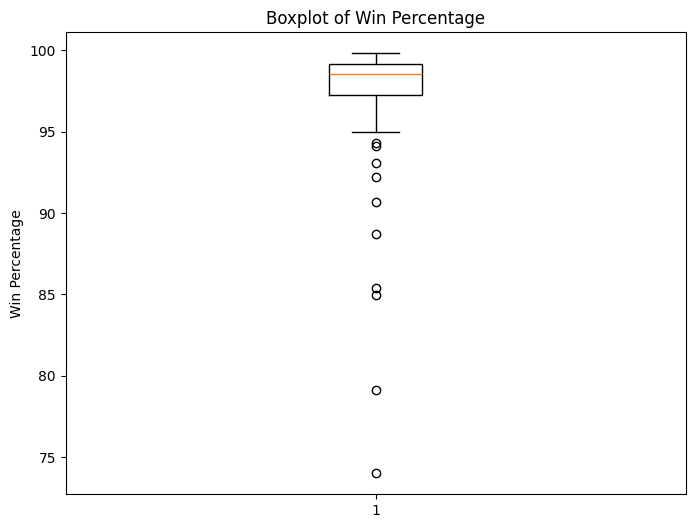

In [35]:
plt.figure(figsize=(8, 6))
plt.boxplot(win_percentage)
plt.title('Boxplot of Win Percentage')
plt.ylabel('Win Percentage')
plt.show()

Il boxplot conferma le nostre ipotesi. Per fare delle osservazioni interessanti allora dobbiamo modificare le probabilità di margine con cui andiamo a categorizzare win_percentage. 